# Training Notebook

Training on Mixed and UT-West-Campus datasets. Evaluate on test portion of both

Train Mask-RCNN + ResNet101 Backbone

Add a couple additional things: 
- Validation Loop using loss 
- Checkpoint based off of best validation metrics
- Custom COCO Style Dataloaders

In [1]:
# python libraries
import os
import json
import random
import math
import time
import datetime
import logging
from glob import glob

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

# d2 libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils import comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import EvalHook, BestCheckpointer
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    get_detection_dataset_dicts,
    DatasetMapper,
)
import detectron2.data.transforms as T
from detectron2.utils.logger import setup_logger

# my stuff
from data_utils import (
    read_split_file,
    register_dataset,
    random_split_mixed_set,
    random_split_ut_west_campus_set
)

# setup D2 logger
setup_logger()

%matplotlib inline

### Randomly Split Mixed Dataset

For reproducibility we seed the shuffler with the value 10

In [2]:
random_split_mixed_set(img_dir="data/panels/mixed", split_ratio=(0.7, 0.1, 0.2), seed=10)
mixed_datasets = read_split_file("data/panels/mixed/split.txt")

### Randomly Split UT-West-Campus Dataset

In [3]:
random_split_ut_west_campus_set("data/panels/ut_west_campus", split_ratio=(0.7, 0.1, 0.2), seed=10)
ut_west_campus_datasets = read_split_file("data/panels/ut_west_campus/split.txt")

### Register Mixed Dataset Splits

In [4]:
classes = ["label", "button"]
colors = [(0, 255, 0), (0, 0, 255)]

dataset_names = [
    "mixed_train",
    "mixed_val",
    "mixed_test",
    "ut_west_campus_train",
    "ut_west_campus_val",
    "ut_west_campus_test",
]

# register combined training and validation sets
for name, im_paths in zip(dataset_names, mixed_datasets + ut_west_campus_datasets):
    DatasetCatalog.register(
        name=name, func=lambda im_paths=im_paths: register_dataset(im_paths=im_paths)
    )
    MetadataCatalog.get(name=name).set(thing_classes=classes, thing_colors=colors)

elevator_metadata = MetadataCatalog.get("mixed_train")

In [5]:
mixed_train = DatasetCatalog.get("mixed_train")
ut_west_campus_train = DatasetCatalog.get("ut_west_campus_train")
trainset = mixed_train + ut_west_campus_train
print("total trainset len: ", len(trainset))

total trainset len:  272


### Visualize Training Data Samples

Ensure that data is annotated correctly

data/panels/ut_west_campus/eer_16.jpg


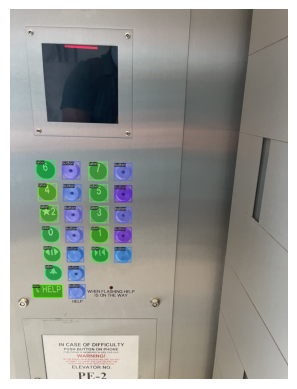

data/panels/ut_west_campus/jester_east_2.jpg


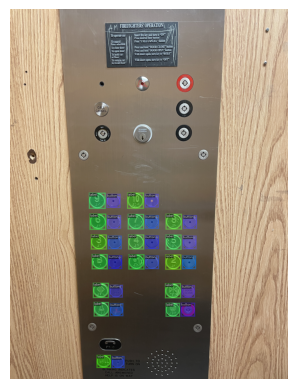

data/panels/ut_west_campus/cpe_17.jpg


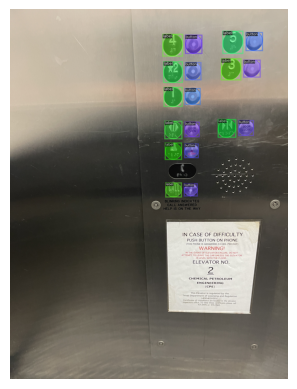

data/panels/mixed/mixed_40.jpg


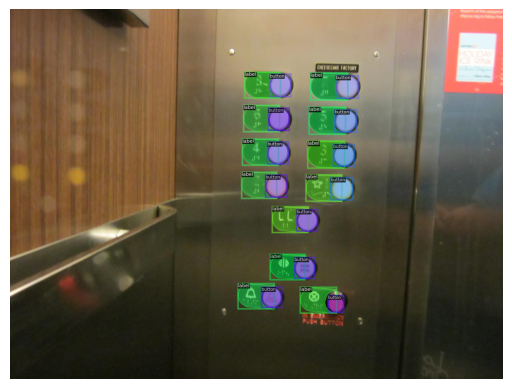

data/panels/ut_west_campus/cpe_5.jpg


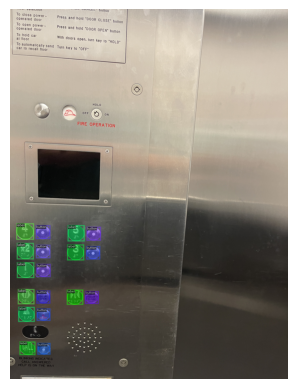

In [6]:
for d in random.sample(trainset, 5):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=elevator_metadata,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Validation Loop using Validation Loss

as opposed to evaluation metrics (AP, Precision, Recall, etc.)

In [7]:
def validation_loop(model: torch.nn, dataloader: torch.utils.data.DataLoader) -> dict:
    """
    Validate model on the given dataloader. Put model in training mode to output loss
    dict but do not backpropogate gradients. Largely adapted from train_loop.py and
    inference_on_dataset

    Args:
        model (torch.nn): model to validate
        dataloader (torch.utils.data.DataLoader): validation dataloader set to training
            mode

    Returns:
        dict: {"validation_loss": val_loss}
    """
    model.train()
    num_batches = len(dataloader)
    num_warmup = min(5, num_batches - 1)
    start_time = time.perf_counter()
    total_compute_time = 0
    losses = []
    for idx, data in enumerate(dataloader):
        if idx == num_warmup:
            start_time = time.perf_counter()
            total_compute_time = 0
        start_compute_time = time.perf_counter()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        total_compute_time += time.perf_counter() - start_compute_time
        iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
        seconds_per_img = total_compute_time / iters_after_start
        if idx >= num_warmup * 2 or seconds_per_img > 5:
            total_seconds_per_img = (
                time.perf_counter() - start_time
            ) / iters_after_start
            eta = datetime.timedelta(
                seconds=int(total_seconds_per_img) * (num_batches - idx - 1)
            )
            log_every_n_seconds(
                logging.INFO,
                "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                    idx + 1, num_batches, seconds_per_img, str(eta)
                ),
                n=5,
            )

        batch_loss_dict = model(data)
        batch_loss_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in batch_loss_dict.items()
        }
        total_batch_loss = sum(loss for loss in batch_loss_dict.values())
        losses.append(total_batch_loss)
    val_loss = np.mean(losses)
    comm.synchronize()
    log_every_n_seconds(logging.INFO, f"VALIDATION_LOSS: {val_loss:.5f}")
    return {"validation_loss": val_loss}

### Define a Custom Trainer

Add custom hooks and dataloaders

In [8]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.TRAIN[0], filter_empty=False
            ),
            mapper=DatasetMapper(
                is_train=True,
                augmentations=[
                    T.ResizeScale(
                        min_scale=0.1,
                        max_scale=2.0,
                        target_height=1024,
                        target_width=1024,
                    ),
                    T.FixedSizeCrop(crop_size=(1024, 1024), pad=False),
                ],
                image_format="RGB",
                use_instance_mask=True,
                recompute_boxes=True,
            ),
            total_batch_size=cfg.SOLVER.IMS_PER_BATCH,
            num_workers=cfg.DATALOADER.NUM_WORKERS,
        )

    @classmethod
    def build_validation_loader(cls, cfg):
        return build_detection_test_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.VAL[0], filter_empty=False
            ),
            mapper=DatasetMapper(
                is_train=True,
                augmentations=[
                    T.ResizeShortestEdge(short_edge_length=1024, max_size=1024)
                ],
                image_format="BGR",
                use_instance_mask=True,
            ),
        )

    def build_hooks(self) -> list:
        """
        Overwrite the evaluation loop and checkpoint using best validation loss

        Returns:
            list: list of hooks
        """
        hooks = super().build_hooks()
        # remove existing EvalHook
        if comm.is_main_process():
            del hooks[-2]
            del hooks[-2]
        else:
            del hooks[-1]
        hooks.extend(
            [
                EvalHook(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    eval_function=lambda: validation_loop(
                        self.model,
                        self.build_validation_loader(self.cfg),
                    ),
                    eval_after_train=True,
                ),
                BestCheckpointer(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    checkpointer=self.checkpointer,
                    val_metric="validation_loss",
                    mode="min",
                ),
            ]
        )
        return hooks

### Define Config for Building Model

Use Mask-RCNN w/ ResNet-101 Backbone

In [9]:
mask_rcnn_res50 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mask_rcnn_res101 = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
cascade_mask_rcnn_res50 = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"

base_cfg = mask_rcnn_res101

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(base_cfg))

# start from pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_cfg)

# assign datasets and adjust ROI HEADS to match num classes
cfg.DATASETS.TRAIN = ("mixed_train", "ut_west_campus_train")
cfg.DATASETS.VAL = ("mixed_val", "ut_west_campus_val")
cfg.DATASETS.TEST = ("mixed_test", "ut_west_campus_test")
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# Calculate training logic
epochs = 100
batch_size = 2
eval_period = 2
iters_per_epoch = math.ceil(len(trainset) / batch_size)

cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * eval_period
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = [int(0.7 * cfg.SOLVER.MAX_ITER), int(0.8 * cfg.SOLVER.MAX_ITER)]
cfg.SOLVER.WARMUP_ITERS = int(0.067 * cfg.SOLVER.MAX_ITER)

# SAVE DIR
cfg.OUTPUT_DIR = "./models/combined_v2"

### Train Configured Model

Use modified DefaultTrainer

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/24 12:34:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/24 12:34:02 d2.engine.train_loop]: Starting training from iteration 0


/home/abhinavchadaga/miniforge3/envs/d2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/24 12:34:08 d2.utils.events]:  eta: 0:53:10  iter: 19  total_loss: 3.804  loss_cls: 1.202  loss_box_reg: 0.7306  loss_mask: 0.6919  loss_rpn_cls: 0.9721  loss_rpn_loc: 0.1277  time: 0.2158  last_time: 0.2410  data_time: 0.0161  last_data_time: 0.0025   lr: 5.4588e-06  max_mem: 3819M
[02/24 12:34:12 d2.utils.events]:  eta: 0:52:16  iter: 39  total_loss: 3.045  loss_cls: 1.074  loss_box_reg: 0.8049  loss_mask: 0.6817  loss_rpn_cls: 0.3981  loss_rpn_loc: 0.0778  time: 0.2080  last_time: 0.2508  data_time: 0.0028  last_data_time: 0.0006   lr: 1.0942e-05  max_mem: 3819M
[02/24 12:34:16 d2.utils.events]:  eta: 0:52:42  iter: 59  total_loss: 2.562  loss_cls: 0.936  loss_box_reg: 0.7914  loss_mask: 0.6545  loss_rpn_cls: 0.06627  loss_rpn_loc: 0.0626  time: 0.2070  last_time: 0.2418  data_time: 0.0066  last_data_time: 0.0034   lr: 1.6425e-05  max_mem: 3819M
[02/24 12:34:20 d2.utils.events]:  eta: 0:52:20  iter: 79  total_loss: 2.394  loss_cls: 0.7874  loss_box_reg: 0.7591  loss_mask: 0.6236

### Plot Training and Validation Curves

In [11]:
def load_json_arr(json_path):
    train, val = [], []
    with open(json_path, "r") as f:
        for line in f:
            line = json.loads(line)
            if "validation_loss" in line:
                val.append(line)
            elif "total_loss" in line:
                train.append(line)
    return train, val

In [12]:
train_metrics, val_metrics = load_json_arr(os.path.join(cfg.OUTPUT_DIR, "metrics.json"))
train_metrics = train_metrics[2:]

In [13]:
train_iters = [x["iteration"] for x in train_metrics]
train_loss = [x["total_loss"] for x in train_metrics]

val_iters = [x["iteration"] for x in val_metrics]
val_loss = [x["validation_loss"] for x in val_metrics]

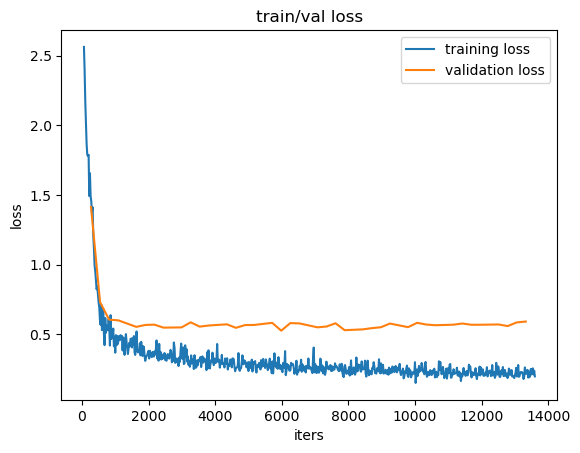

In [14]:
plt.plot(train_iters, train_loss)
plt.plot(val_iters, val_loss)
plt.xlabel("iters")
plt.ylabel("loss")
plt.title("train/val loss")
plt.legend(["training loss", "validation loss"], loc="upper right")
plt.show()

### Evalatuate Model on Mixed Testset

Using Default Predictor with Threshold of 0.7

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/24 13:24:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/combined_v2/model_best.pth ...


In [16]:
evaluator = COCOEvaluator(
    dataset_name="mixed_test",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "inference", "mixed"),
    allow_cached_coco=False,
    use_fast_impl=False,
)
testloader = build_detection_test_loader(cfg, "mixed_test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

[02/24 13:24:24 d2.evaluation.coco_evaluation]: Trying to convert 'mixed_test' to COCO format ...
[02/24 13:24:24 d2.data.datasets.coco]: Converting annotations of dataset 'mixed_test' to COCO format ...)
[02/24 13:24:24 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/24 13:24:24 d2.data.datasets.coco]: Conversion finished, #images: 20, #annotations: 790
[02/24 13:24:24 d2.data.datasets.coco]: Caching COCO format annotations at './models/combined_v2/inference/mixed/mixed_test_coco_format.json' ...
[02/24 13:24:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/24 13:24:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/24 13:24:25 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[02/24 13:24:25 d2.data.common]: Serialized dataset takes 2.97 MiB
[02/24 

### Visualize Inference on Mixed Testset

In [17]:
def visualize_inference(dataset_name: str, k: int):
    testset = get_detection_dataset_dicts(dataset_name, filter_empty=False)
    for d in random.sample(testset, k):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(
            img[:, :, ::-1],
            metadata=MetadataCatalog.get(dataset_name),
            scale=1.0,
            instance_mode=ColorMode.SEGMENTATION,
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(out.get_image())
        plt.axis("off")
        plt.show()

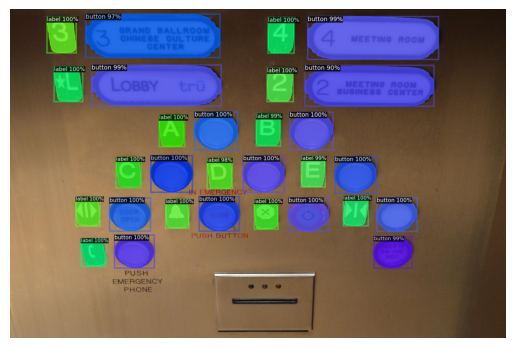

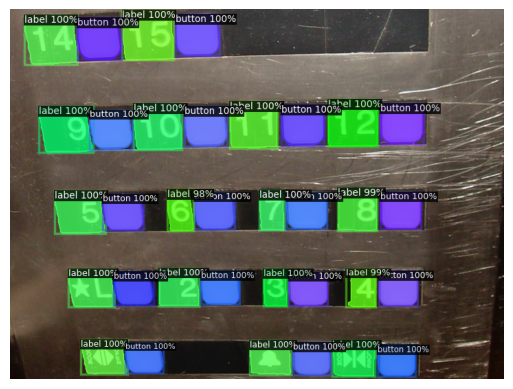

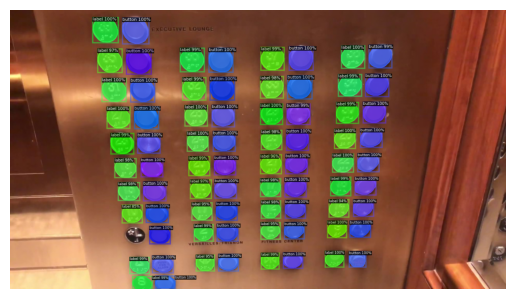

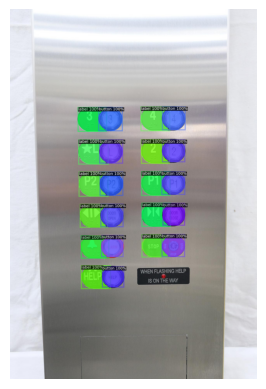

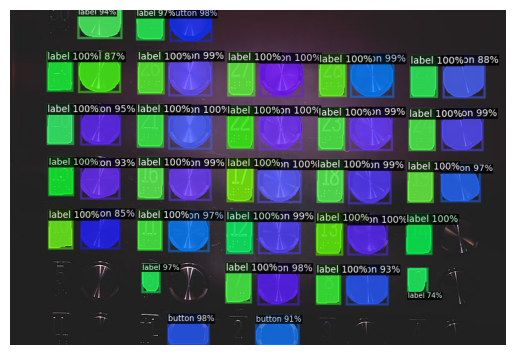

In [18]:
visualize_inference("mixed_test", 5)

### Evaluate Model on UT-West-Campus Testset

In [19]:
evaluator = COCOEvaluator(
    dataset_name="ut_west_campus_test",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "inference", "ut_west_campus"),
    allow_cached_coco=False,
    use_fast_impl=False,
)
testloader = build_detection_test_loader(cfg, "ut_west_campus_test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

[02/24 13:24:33 d2.evaluation.coco_evaluation]: Trying to convert 'ut_west_campus_test' to COCO format ...
[02/24 13:24:33 d2.data.datasets.coco]: Converting annotations of dataset 'ut_west_campus_test' to COCO format ...)
[02/24 13:24:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/24 13:24:42 d2.data.datasets.coco]: Conversion finished, #images: 70, #annotations: 1576
[02/24 13:24:42 d2.data.datasets.coco]: Caching COCO format annotations at './models/combined_v2/inference/ut_west_campus/ut_west_campus_test_coco_format.json' ...
[02/24 13:24:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/24 13:24:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/24 13:24:53 d2.data.common]: Serializing 70 elements to byte tensors and concatenating them all ...
[02/24 13:24:54 d2.data.common]: Seri

### Visualize Inference on UT-West-Campus Testset

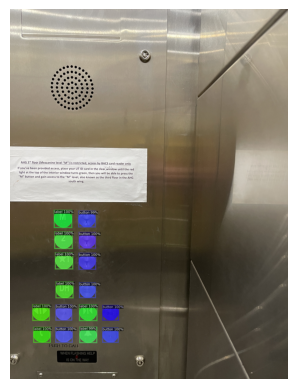

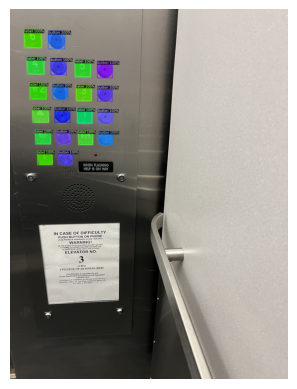

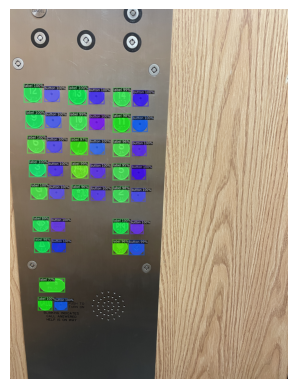

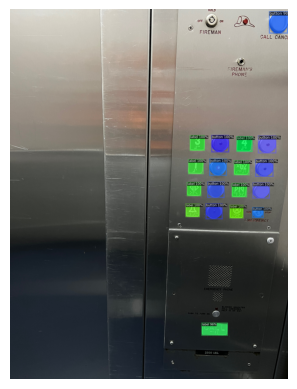

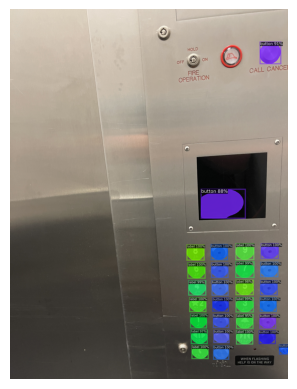

In [20]:
visualize_inference("ut_west_campus_test", 5)